# DATA precessing


> Imports



In [ ]:
import os
import math
import numpy as np
from numpy import array
from numpy import hstack
import pandas as pd
import netCDF4
import xarray as xr
import pickle
import tensorflow as tf
import seaborn as sns

import keras
from keras import layers, losses, regularizers
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.models import Model, load_model
from keras.layers import Input, Dense, Flatten, Reshape, LeakyReLU, Cropping2D, RepeatVector, TimeDistributed, LSTM

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, auc, precision_recall_curve

import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/My Drive/')
os.getcwd()
if not os.path.exists('JULES'):
        os.makedirs('JULES')
        



> Download the data



In [ ]:
total_paths = []
# tair rain qair lighting
root_path = os.walk("data5/")
for path,dir_list,file_list in root_path:
    for file_name in file_list:
      total_paths.append(str(os.path.join(path, file_name)))
print(len(total_paths))


30


In [ ]:
total_paths.sort();
for i in range(30):
  print(total_paths[i])


data5/JULES-ES.1p0.vn5.4.50.fireMIP.LGM.365x30.p5.S2.Monthly.1961.nc
data5/JULES-ES.1p0.vn5.4.50.fireMIP.LGM.365x30.p5.S2.Monthly.1962.nc
data5/JULES-ES.1p0.vn5.4.50.fireMIP.LGM.365x30.p5.S2.Monthly.1963.nc
data5/JULES-ES.1p0.vn5.4.50.fireMIP.LGM.365x30.p5.S2.Monthly.1964.nc
data5/JULES-ES.1p0.vn5.4.50.fireMIP.LGM.365x30.p5.S2.Monthly.1965.nc
data5/JULES-ES.1p0.vn5.4.50.fireMIP.LGM.365x30.p5.S2.Monthly.1966.nc
data5/JULES-ES.1p0.vn5.4.50.fireMIP.LGM.365x30.p5.S2.Monthly.1967.nc
data5/JULES-ES.1p0.vn5.4.50.fireMIP.LGM.365x30.p5.S2.Monthly.1968.nc
data5/JULES-ES.1p0.vn5.4.50.fireMIP.LGM.365x30.p5.S2.Monthly.1969.nc
data5/JULES-ES.1p0.vn5.4.50.fireMIP.LGM.365x30.p5.S2.Monthly.1970.nc
data5/JULES-ES.1p0.vn5.4.50.fireMIP.LGM.365x30.p5.S2.Monthly.1971.nc
data5/JULES-ES.1p0.vn5.4.50.fireMIP.LGM.365x30.p5.S2.Monthly.1972.nc
data5/JULES-ES.1p0.vn5.4.50.fireMIP.LGM.365x30.p5.S2.Monthly.1973.nc
data5/JULES-ES.1p0.vn5.4.50.fireMIP.LGM.365x30.p5.S2.Monthly.1974.nc
data5/JULES-ES.1p0.vn5.4.50.fireMI

In [ ]:
this_file = netCDF4.Dataset(total_paths[0])

In [ ]:
print(this_file.variables.keys())

dict_keys(['time_bounds', 'time', 'latitude', 'longitude', 'mrro', 'sh', 'Ts', 'mrso', 'gpp', 'npp', 'ra', 'rh', 'tsl', 'msl', 'ecan_gb', 'esoil_gb', 'fqw_gb', 'sw_down', 'sw_net', 'lwup', 'ghflx', 'snow_mass', 'snow_depth', 'landCoverFrac', 'npp_pft', 'gpp_pft', 'canht', 'lai', 'co2_mmr', 'et_stom', 'et_stom_gb', 'surf_roff', 'zw', 'fsat', 'fwet', 'fsmc', 'fsmc_gb', 'burnt_area_gb', 'emitted_carbon_gb', 'fire_em_CO2_gb', 'c_veg', 'burnt_area_pft', 'emitted_carbon_pft', 'flammability_pft', 'fire_mcarthur', 'fire_nesterov', 'fire_canadian', 'precip', 't1p5m_gb', 'wind', 'cv', 'leafC', 'rootC', 'woodC', 'lit_c', 'lit_c_mean', 'cs_gb', 'fire_em_CO_gb'])




## Processing for climate data



In [ ]:
# Temperature  Total_Precipitation  Air_Specific_Humidity  lght
# tmp pre spfh Cloud2Ground
np.array(this_file['tmp']).shape


(1460, 144, 192)

In [ ]:
# light_data = np.array(this_file['Cloud2Ground'])
# plt.imshow(light_data[8])
# plt.colorbar()
# plt.show()

# total_lght = []
# light_data = np.reshape(light_data, (12, 27648))
# for i in range(30):
#   total_lght.append(light_data)

# total_lght = np.reshape(total_lght, (360, 27648))
# total_lght = np.array(total_lght)
# lght_df = pd.DataFrame(total_lght)
# lght_df.to_csv('JULES/pt_lighting.csv')


In [ ]:
# plt.imshow(this_file['tmp'][8]) # Temperature
# plt.colorbar()
# plt.show()

In [ ]:
# plt.imshow(this_file['pre'][0])# Total_Precipitation
# plt.colorbar()
# plt.show()

In [ ]:
# plt.imshow(this_file['spfh'][0]) # Air_Specific_Humidity
# plt.colorbar()
# plt.show()

In [ ]:
import math
from sklearn import preprocessing
      
def obtain_climate_data(total_paths, name):

  sample_num = 12*len(total_paths)
  feature_num = 144 * 192 # int(len(x_list) * len(y_list))
  time = 1460 # np.array(no_0['time']).shape[0]
  each_month = math.ceil(time/12)
  print(time, each_month)
  raw_data = np.zeros((sample_num,feature_num))

  for k in range(len(total_paths)):
    this_file = netCDF4.Dataset(total_paths[k])
    count = 0
    for j in range(12):
      field = np.zeros((144, 192))
      if (count + each_month) < time:
        for i in range(each_month):
          field = field + this_file[str(name)][i+count]
        field = field/each_month
        count = count + each_month
      else:
        size = time - count
        for i in range(size):
          field = field + this_file[str(name)][i+count]
        field = field/each_month
        count = count + size
      # plt.imshow(field)
      # plt.colorbar()
      # plt.show()
      for m in range(144):
        for n in range(192):
          raw_data[k*12+j, m*192+n] = field[m, n]
      if (j%6 == 0):
        print(k*12+j)
  return raw_data
  

In [ ]:
# Temperature  Total_Precipitation  Air_Specific_Humidity
# tmp pre spfh
climate_data = obtain_climate_data(total_paths, "tmp")
print(climate_data.shape)




> Store the climate data



In [ ]:
# tair rain qair
climate_df = pd.DataFrame(climate_data)
climate_df.to_csv('JULES/pt_tair.csv')

# climatt = pd.read_csv('JULES/testt.csv', index_col=0)
# print(climatt.head(5))
# this_data = climatt.values
# print(this_data[0])


## Processing for fire data



> Store the 7771 “burnt_area_gb” data for each month in a plannar interval of size 112*192 (unique latitude and longitude number)



In [ ]:
def obtain_gb_data(total_paths):
  no_0 = netCDF4.Dataset(total_paths[0])
  x_list = list(np.unique(np.array(no_0['latitude'])))
  y_list = list(np.unique(np.array(no_0['longitude'])))
  print(len(x_list),len(y_list))

  sample_num = 12*len(total_paths)
  feature_num = int(len(x_list) * len(y_list))

  raw_data = np.zeros((sample_num,feature_num))

  for k in range(len(total_paths)):
    this_file = netCDF4.Dataset(total_paths[k])
    for j in range(12):
      field = np.zeros((len(x_list),len(y_list)))
      for i in range(np.array(this_file['latitude']).size):
        index_x = x_list.index(np.array(this_file['latitude']).ravel()[i])
        index_y = y_list.index(np.array(this_file['longitude']).ravel()[i])
        field[index_x,index_y] = np.array(this_file['burnt_area_gb'][j][0][i])
      # plt.imshow(field)
      # plt.show()
      for m in range(len(x_list)):
        for n in range(len(y_list)):
          raw_data[k*12+j, m*len(y_list)+n] = field[m, n]
      if (j%6 == 0):
        print(k*12+j)
  return raw_data
  

In [ ]:
gb_data = obtain_gb_data(total_paths)
print(gb_data.shape)


112 192
0
6
12
18
24
30
36
42
48
54
60
66
72
78
84
90
96
102
108
114
120
126
132
138
144
150
156
162
168
174
180
186
192
198
204
210
216
222
228
234
240
246
252
258
264
270
276
282
288
294
300
306
312
318
324
330
336
342
348
354
(360, 21504)



> Store it in the csv, convenient to call directly next time



In [ ]:
df = pd.DataFrame(gb_data)
df.to_csv('JULES/gb_data5.csv')


In [ ]:
print(df.head())


   0      1      2      3      4      5      6      7      8      9      ...  \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   

   21494  21495  21496  21497  21498  21499  21500  21501  21502  21503  
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[5 rows x 21504 columns]



> READ the data from csv


In [ ]:

gb_df = pd.read_csv('JULES/gb_dataT.csv', index_col=0)
print(gb_df.head(5))
gb_data = gb_df.values
print(gb_data.shape)

     0    1    2    3    4    5    6    7    8    9  ...  21494  21495  21496  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   

   21497  21498  21499  21500  21501  21502  21503  
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[5 rows x 21504 columns]
(360, 21504)


In [ ]:
def show_comp(original_test_data):
  plt.figure(figsize=(24, 12), facecolor='w')
  monthly_field = np.zeros((112, 192))

  for j in range(12):
    plt.subplot(3, 4, j+1)
    monthly_field = np.zeros((112, 192))
    for i in range(21504):
        monthly_field[i//192,i%192] = np.array(original_test_data[j+300][i])
    plt.title(f'The {j + 1} oringinal')
    plt.imshow(monthly_field)
    plt.colorbar()
  plt.show()

In [ ]:
show_comp(gb_data)

(360, 21504)


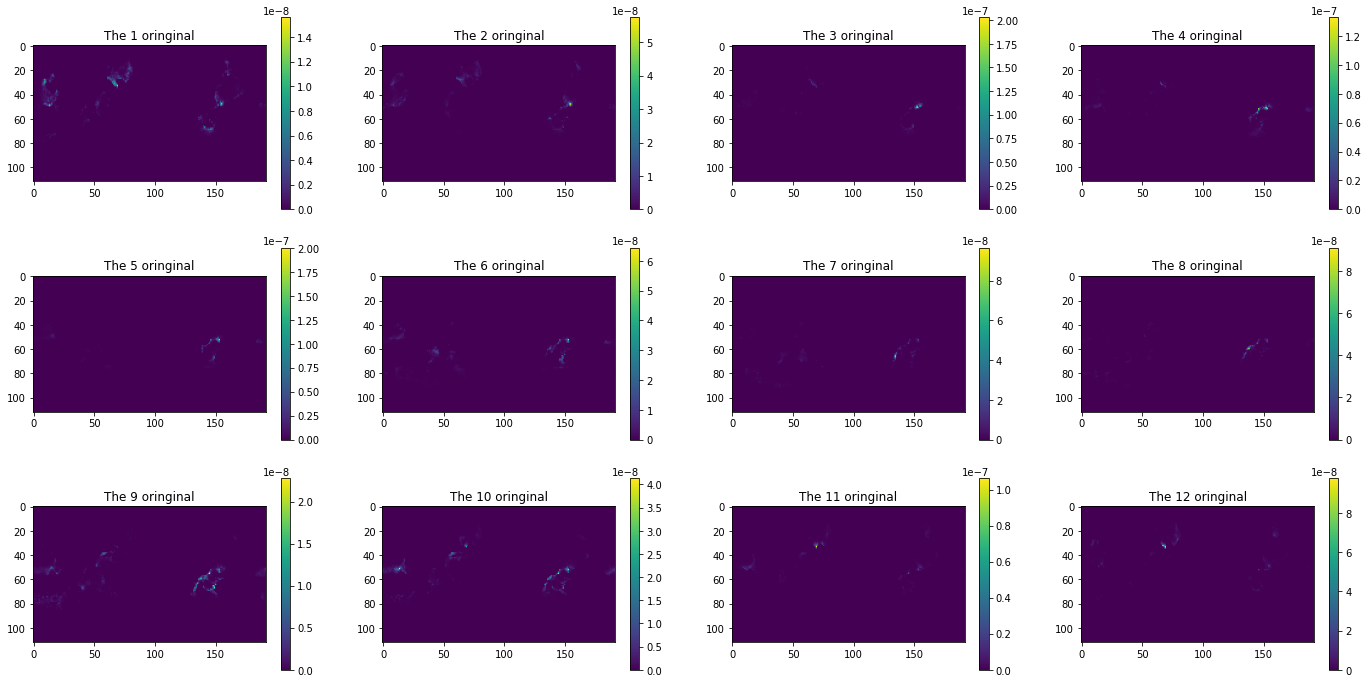

In [ ]:
gb_df2 = pd.read_csv('JULES/gb_data.csv', index_col=0)
gb_data2 = gb_df2.values
print(gb_data2.shape)
show_comp(gb_data2)
